# Simple Smoothing 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
# KPI measure
# Calculate in python with bias and scaled bias
def kpi(df):
	demand_average = df.loc[df['Error'].notnull(), 'Demand'].mean()
	bias_abs = df['Error'].mean()
	bias_scaled = bias_abs / demand_average * 100
	MAPE = (df['Error'].abs() / df['Demand']).mean()
	MAE_abs = df['Error'].abs().mean()
	MAE_scale = MAE_abs / demand_average * 100
	RMSE_abs = np.sqrt((df['Error']**2).mean())
	RMSE_scale = RMSE_abs / demand_average * 100
	print(f"Bias:{bias_abs:.2f}, {bias_scaled:.2f}")
	print(f"MAPE is {MAPE:.2f}%")
	print(f"MAE is {MAE_abs:.2f} and MAE scaled is {MAE_scale:.2f}%")
	print(f"RMSE is {RMSE_abs:.2f} and RMSE scaled is {RMSE_scale:.2f}%")

Note for `simple smoothing`:

1. F1 = L0 - this mean the previous level equals the next forecast (because in this method just only focus on level)

2. L0 = the average of all actual demand

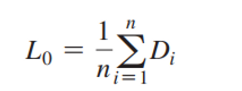

In [3]:
D_value = np.array([38,35,77,90])
# Calculate L0
L0 = np.average(D_value)
 


def simple_smoothing(a, D, pre_forecast):
    forecast = pre_forecast + a * (D - pre_forecast)
    pre_forecast = forecast
    forecast = np.round(forecast,2)
    return forecast, pre_forecast

simple_smoothing(0.1, 38, 60) # result is 57.8


n = 4
a = 0.1 # smooth constant
pre_forecast = L0 # the first level in period 0

for i in range(n):
    D = D_value[i]
    forecast, pre_forecast = simple_smoothing(a, D, pre_forecast)
    print(f"Forecast for D with time {i} is = {D}: {forecast}")

Forecast for D with time 0 is = 38: 57.8
Forecast for D with time 1 is = 35: 55.52
Forecast for D with time 2 is = 77: 57.67
Forecast for D with time 3 is = 90: 60.9


## Exponential Smoothing in DataFrame

In [4]:
def exponential_smoothing(d, extra_periods=1,alpha=0.4):
	
	#Historical length
	cols = len(d)

	# Append np.nan
	d = np.append(d,[np.nan]*extra_periods)

	# Forecasting array
	f = np.full(cols + extra_periods, np.nan)
	# initialization of first forecast
	f[1] = d[0]

	# Create all the t+1 forecast until end historical data
	for t in range(2,cols+1):
			f[t] = alpha*d[t-1] + (1-alpha)*f[t-1]

	# Forecast for all extra periods
	for t in range(cols+1,cols+extra_periods):
		# Update the forecast as the previous forecast
			f[t] = f[t-1]

	df = pd.DataFrame.from_dict({
			'Demand':d,
			'Forecast':f,
			'Error':d-f
		})

	return df

In [5]:
# test
d = [28,19,18,13,19,16,19,18,13,16,16,11,18,15,13,15,13,11,13,10,12]
df_3_alpha = exponential_smoothing(d,extra_periods=4,alpha=0.4)



In [6]:
fig = px.line(
    df_3_alpha,
    y = ['Demand','Forecast'],
    title = 'Relationship between Demand and Forecast with learning rate 0.3 in ES',
    # hover_name='Period'
)

fig.update_layout(
    legend_title = {
        'text':'Observation Variable',
        'font_family':'Comic Sans',
        'font_size':16,
        'font_color':'green'
    },
    hovermode = 'x unified',
    title = {
        'x':0.45,
        'y':0.88,
        'xanchor':'center'
    },
    width = 900,
    height = 600
)

fig.update_traces(
    mode = 'markers+lines',
    hovertemplate = None
)

fig.update_xaxes(
    title = 'Period',
    showgrid = False,
    dtick = 3
)

fig.update_yaxes(
    showgrid = False
)


In [7]:
# Check kpi
kpi(df_3_alpha)

Bias:-2.02, -13.56
MAPE is 0.19%
MAE is 2.74 and MAE scaled is 18.39%
RMSE is 3.89 and RMSE scaled is 26.11%


# Double Exponential Smoothing

In [8]:
def double_exponential_smoothing(d, extra_periods=1, alpha=0.4, beta=0.3):

    # Count the length of d
    cols = len(d)

    # append the np.nan into d
    d = np.append(d,[np.nan]*extra_periods)

    # Creation of full extra period, level and trend
    f,a,b = np.full((3,cols + extra_periods), np.nan)

    # Level and Trend Initialization
    a[0] = d[0]
    b[0] = d[1] - d[0]

    # Create all t+1 forecast
    for t in range (1, cols):
        f[t] = a[t-1] + b[t-1]
        a[t] = alpha*d[t] + (1-alpha)*(a[t-1] + b[t-1])
        b[t] = beta*(a[t] - a[t-1]) + (1-beta)*b[t-1]

    # Forecast extra periods
    for t in range(cols, cols+extra_periods):
        f[t] = a[t-1] + b[t-1]
        a[t] = f[t]
        b[t] = b[t-1]

    df = pd.DataFrame.from_dict({
        'Level':a,
        'Trend':b,
        'Demand':d,
        'Forecast':np.round(f,2),
        'Error':np.round(d-f,2)
    })

    return df

In [9]:
d = [28,19,18,13,19,16,19,18,13,16,16,11,18,15,13,15,13,11,13,10,12]
df_double_ex1 = double_exponential_smoothing(d,extra_periods=4,alpha=0.6,beta=0.7)
df_double_ex1

,Level,Trend,Demand,Forecast,Error
0,28.000000,-9.000000,28.0,NaN,NaN
1,19.000000,-9.000000,19.0,19.00,0.00
2,14.800000,-5.640000,18.0,10.00,8.00
3,11.464000,-4.027200,13.0,9.16,3.84
4,14.374720,0.829344,19.0,7.44,11.56
5,15.681626,1.163637,16.0,15.20,0.80
6,18.138105,2.068627,19.0,16.85,2.15
7,18.882693,1.141799,18.0,20.21,-2.21
8,15.809797,-1.808487,13.0,20.02,-7.02
9,15.200524,-0.969037,16.0,14.00,2.00


In [10]:
kpi(df_double_ex1)

Bias:1.07, 7.19
MAPE is 0.22%
MAE is 3.32 and MAE scaled is 22.28%
RMSE is 4.38 and RMSE scaled is 29.36%


In [11]:
fig = px.line(
    df_double_ex1,
    y = ['Demand','Forecast'],
    title = 'Relationship between Demand and Forecast with learning rate 0.3 in ES',
    # hover_name='Period'
)

fig.update_layout(
    legend_title = {
        'text':'Observation Variable',
        'font_family':'Comic Sans',
        'font_size':16,
        'font_color':'green'
    },
    hovermode = 'x unified',
    title = {
        'x':0.45,
        'y':0.88,
        'xanchor':'center'
    },
    width = 900,
    height = 600
)

fig.update_traces(
    mode = 'markers+lines',
    hovertemplate = None
)

fig.update_xaxes(
    title = 'Period',
    showgrid = False,
    dtick = 3
)

fig.update_yaxes(
    showgrid = False
)


# Trend-Corrected Exponential Smoothing 

In [12]:
def trend_corrected(a,b,pre_level,pre_trend,D):
    level = a*D + (1-a)*(pre_level + pre_trend)
    trend = b*(level - pre_level) + (1-b)*pre_trend 
    forecast = level+trend
    forecast = np.round(forecast,2)
    return forecast, level, trend

trend_corrected(0.1,0.2,2604841.93,548247.4,3417774)

n = 6  # Number of times to calculate forecast
a = 0.1
b = 0.2
pre_level = 2604841.93
pre_trend = 548247.4
D_values = np.array([3417774,3511513,4208095,4627478,5247125,6130262])

for i in range(n):
    D = D_values[i]
    forecast, pre_level, pre_trend = trend_corrected(a, b, pre_level, pre_trend, D)
    print(f"Forecast for D with time {i} is = {D}: {forecast}")
    print(f"Previous Level for D  with time {i} is = {D}: {pre_level}")
    print(f"Previous Trend for D with time {i} is = {D}: {pre_trend}")



Forecast for D with time 0 is = 3417774: 3733098.89
Previous Level for D  with time 0 is = 3417774: 3179557.7970000003
Previous Trend for D with time 0 is = 3417774: 553541.0934000001
Forecast for D with time 1 is = 3511513: 4260049.68
Previous Level for D  with time 1 is = 3511513: 3710940.301360001
Previous Trend for D with time 1 is = 3511513: 549109.3755920003
Forecast for D with time 2 is = 4208095: 4802924.49
Previous Level for D  with time 2 is = 4208095: 4254854.209256801
Previous Trend for D with time 2 is = 4208095: 548070.2820529602
Forecast for D with time 3 is = 4627478: 5329941.19
Previous Level for D  with time 3 is = 4627478: 4785379.842178785
Previous Trend for D with time 3 is = 4627478: 544561.3522267651
Forecast for D with time 4 is = 5247125: 5864564.6
Previous Level for D  with time 4 is = 5247125: 5321659.5749649955
Previous Trend for D with time 4 is = 5247125: 542905.0283386542
Forecast for D with time 5 is = 6130262: 6439353.32
Previous Level for D  with time 

# Moving Average

In [13]:
# do it yourself
def moving_average(d, extra_periods = 1, n=3):
	'''
		Extra_period = the period you want to forecast
		n mean the number using previous for forecasting
	'''

	#Historical period length
	cols = len(d)

	# append np.nan into demand array to cover future period
	d = np.append(d, [np.nan]*extra_periods)
	
	# Define the forecast array
	f = np.full(cols+extra_periods, np.nan)

	# Create all the t+1 forecast until end of historical period
	for t in range(n,cols):
		f[t] = np.mean(d[t-n:t])

	# Forecast for all extra periods
	f[t+1:] = np.mean(d[t-n+1:t+1])

	# Return a DataFrame with the demand, forecast & error
	df = pd.DataFrame.from_dict({
		'Demand':d,
		'Forecast' : f,
		'Error' : d-f	
		})

	return df

In [14]:
d = [28,19,18,13,19,16,19,18,13,16,16,11,18,15,13,15,13,11,13,10,12]

df_3 = moving_average(d,extra_periods=4,n=3)

df_2 = moving_average(d,extra_periods=4,n=2)

df_1 = moving_average(d,extra_periods=4,n=1)

In [15]:
px.line(
    df_2,
    y = ['Demand','Forecast'],
    color_discrete_sequence=px.colors.qualitative.Vivid,
    # hover_name={'variables':'observation'},
    title = 'Moving Average with 3 previous period',
    labels={
        'value':'Value',
        'index':'period'
    }
).update_layout(
    legend_title = {
        'text':'Observation',
        'font_size':16,
        'font_family':'Comic Sans'
    }
)

In [16]:
kpi(df_2)

Bias:-0.84, -5.73
MAPE is 0.17%
MAE is 2.42 and MAE scaled is 16.49%
RMSE is 3.09 and RMSE scaled is 21.08%


### Model Optimization

Using the loop to find the best alpha and beta to make the smallest MAE or RMSE

In [17]:
# introduce some new method
np.argmin([1,2,3,4,-20]) # return the index of min


4

In [18]:
def exp_smooth_optimization(d, extra_periods = 6):
    params = [] # contains all the different parameter sets
    KPIs = [] # contains all the result of each model
    dfs = [] # contains all DataFrame return by the different models
    step = 0.05

    # for alpha in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]:
    for alpha in [i*step for i in range(int(1 / step) + 1)]:
        df = exponential_smoothing(
             d, extra_periods=extra_periods,
            alpha = alpha
        )

        params.append(f"Simple Exponential Smoothing with alpha: {alpha}.")
        dfs.append(df)
        MAE = df['Error'].abs().mean()
        # Can use smallest RMSE
        # RMSE = np.sqrt(df['Error']**2).mean()
        KPIs.append(MAE)

        #for beta in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]:
        for beta in [i*step for i in range(int(1 / step) + 1)]:
            df = double_exponential_smoothing(
                d, extra_periods=extra_periods,
                alpha=alpha, beta=beta
            )

            params.append(f"Double Exponential Smoothing with alpha: {alpha}; beta: {beta}.")
            dfs.append(df)
            MAE = df['Error'].abs().mean()
            # Can use smallest RMSE
            # RMSE = np.sqrt(df['Error']**2).mean()
            KPIs.append(MAE)

    mini = np.argmin(KPIs)
    print(f"Best Solution found for {params[mini]} MAE of",round(KPIs[mini],2))

    return dfs[mini]



In [19]:
d = [28,19,18,13,19,16,19,18,13,16,16,11,18,15,13,15,13,11,13,10,12]

df_opti_1 = exp_smooth_optimization(d, extra_periods=6)
df_opti_1

Best Solution found for Simple Exponential Smoothing with alpha: 0.4. MAE of 2.74


,Demand,Forecast,Error
0,28.0,NaN,NaN
1,19.0,28.000000,-9.000000
2,18.0,24.400000,-6.400000
3,13.0,21.840000,-8.840000
4,19.0,18.304000,0.696000
5,16.0,18.582400,-2.582400
6,19.0,17.549440,1.450560
7,18.0,18.129664,-0.129664
8,13.0,18.077798,-5.077798
9,16.0,16.046679,-0.046679


In [20]:
fig = px.line(
    df_opti_1,
    y = ['Demand','Forecast'],
    title = "Relationship between with Demand and Forecast with Smallest MAE",
    # hover_name='Period'
)

fig.update_layout(
    legend_title = {
        'text':'Observation Variable',
        'font_family':'Comic Sans',
        'font_size':16,
        'font_color':'green'
    },
    hovermode = 'x unified',
    title = {
        'x':0.45,
        'y':0.88,
        'xanchor':'center'
    },
    width = 900,
    height = 600
)

fig.update_traces(
    mode = 'markers+lines',
    hovertemplate = None
)

fig.update_xaxes(
    title = 'Period',
    showgrid = False,
    dtick = 3
)

fig.update_yaxes(
    showgrid = False
)


## Double Exponential Smoothing with Damping Trend

In [21]:
def double_exponential_smoothing_damp(d, extra_periods=1, alpha=0.4, beta=0.3, phi=0.8):

    # Count the length of d
    cols = len(d)

    # append the np.nan into d
    d = np.append(d,[np.nan]*extra_periods)

    # Creation of full extra period, level and trend
    f,a,b = np.full((3,cols + extra_periods), np.nan)

    # Level and Trend Initialization
    a[0] = d[0]
    b[0] = d[1] - d[0]

    # Create all t+1 forecast
    for t in range (1, cols):
        f[t] = a[t-1] + phi*b[t-1]
        a[t] = alpha*d[t] + (1-alpha)*(a[t-1] + phi*b[t-1])
        b[t] = beta*(a[t] - a[t-1]) + (1-beta)*phi*b[t-1]

    # Forecast extra periods
    for t in range(cols, cols+extra_periods):
        f[t] = a[t-1] + phi*b[t-1]
        a[t] = f[t]
        b[t] = phi*b[t-1]

    df = pd.DataFrame.from_dict({
        'Level':np.round(a,2),
        'Trend':np.round(b,2),
        'Demand':d,
        'Forecast':np.round(f,2),
        'Error':np.round(d-f,2)
    })

    return df

In [22]:
d = [28,19,18,13,19,16,19,18,13,16,16,11,18,15,13,15,13,11,13,10,12]

df_double_dam_1 = double_exponential_smoothing_damp(d, extra_periods=1, alpha=0.3, beta=0.4, phi=0.8)
df_double_dam_1

,Level,Trend,Demand,Forecast,Error
0,28.00,-9.00,28.0,NaN,NaN
1,20.26,-7.42,19.0,20.80,-1.80
2,15.43,-5.49,18.0,14.33,3.67
3,11.62,-4.16,13.0,11.04,1.96
4,11.51,-2.04,19.0,8.30,10.70
5,11.71,-0.90,16.0,9.88,6.12
6,13.40,0.24,19.0,10.99,8.01
7,14.91,0.72,18.0,13.59,4.41
8,14.74,0.28,13.0,15.49,-2.49
9,15.28,0.35,16.0,14.97,1.03


In [23]:
fig = px.line(
    df_double_dam_1,
    y = ['Demand','Forecast'],
    title = "Relationship between with Demand and Forecast in Damping Trend",
    # hover_name='Period'
)

fig.update_layout(
    legend_title = {
        'text':'Observation Variable',
        'font_family':'Comic Sans',
        'font_size':16,
        'font_color':'green'
    },
    hovermode = 'x unified',
    title = {
        'x':0.45,
        'y':0.88,
        'xanchor':'center'
    },
    width = 900,
    height = 600
)

fig.update_traces(
    mode = 'markers+lines',
    hovertemplate = None
)

fig.update_xaxes(
    title = 'Period',
    showgrid = False,
    dtick = 3
)

fig.update_yaxes(
    showgrid = False
)

In [24]:
kpi(df_double_dam_1)

Bias:1.15, 7.69
MAPE is 0.20%
MAE is 3.04 and MAE scaled is 20.43%
RMSE is 4.04 and RMSE scaled is 27.10%


# Triple Exponential Smoothing

## Calculate the seasonal factors

In [25]:
def seasonal_factors_initialize(s,d,slen,cols):
    for i in range(slen):
        s[i] = np.mean(d[i:cols:slen]) # season average
    
    s /= np.mean(s[:slen]) # scale on seasonal factor in sum of period and mean is 1

    return s



## Define the triple exponential smoothing

In [26]:
def triple_exponential_smoothing(d, slen = 12, extra_periods = 4, alpha = 0.4, beta = 0.3, gamma = 0.2, phi = 0.8):
    # Calculate number of cols
    cols = len(d)

    d = np.append(d,[np.nan]*extra_periods) #Append np.nan into the demand array to cover future periods

    # Component initialization
    f,a,b,s = np.full((4,cols+extra_periods),np.nan)

    s = seasonal_factors_initialize(s,d,slen,cols)
    # Level and Trend Initialization
    a[0] = d[0]/s[0]
    b[0] = d[1] / s[1] - d[0] / s[0]

    # Create a forecast for first seasonal period
    for t in range(1,slen):
        f[t] = (a[t-1] + phi*b[t-1])*s[t]
        a[t] = alpha*(d[t] / s[t]) + (1-alpha)*(a[t-1] + phi*b[t-1])
        b[t] = beta*(a[t] - a[t-1]) + (1-beta)*phi*b[t-1]

    # Create forecast t+1 for historical demand
    for t in range(slen,cols):
        f[t] = (a[t-1] + phi*b[t-1])*s[t-slen]
        a[t] = alpha*(d[t] / s[t-slen]) + (1-alpha)*(a[t-1] + phi*b[t-1])
        b[t] = beta*(a[t] - a[t-1]) + (1-beta)*phi*b[t-1]
        s[t] = gamma*(d[t] / a[t]) + (1-gamma)*s[t-slen]

    # Create forecast for all period
    for t in range(cols,cols+extra_periods):
        f[t] = (a[t-1] + phi*b[t-1])*s[t-slen]
        a[t] = f[t] / s[t-slen]
        b[t] = phi*b[t-1]
        s[t] = s[t-slen]

    # Create dataframe
    df = pd.DataFrame.from_dict({
        'Demand':d,
        'Forecast':np.round(f,2),
        'Error':d-f,
        'Level':a,
        'Trend':b,
        'Seasonal':s
    })

    return df



In [27]:
d = [14,10,6,2,18,8,4,1,16,9,5,3,18,11,4,2,17,9,5,1]

In [28]:
df_triple_expo = triple_exponential_smoothing(d,extra_periods=4,slen=4,alpha=0.8,beta=0.1,phi=0.8,gamma=0.4)
df_triple_expo

,Demand,Forecast,Error,Level,Trend,Seasonal
0,14.0,NaN,NaN,6.873494,1.796719,2.036810
1,10.0,9.59,0.414458,8.598344,1.466123,1.153374
2,6.0,5.75,0.245158,10.104248,1.206199,0.588957
3,2.0,2.44,-0.444733,9.458286,0.803867,0.220859
4,18.0,20.57,-2.574589,9.090155,0.541971,2.014152
5,8.0,10.98,-2.984427,7.453683,0.226572,1.121343
6,4.0,4.50,-0.496652,6.960321,0.113796,0.583249
7,1.0,1.56,-0.557355,5.032494,-0.110850,0.211999
8,16.0,9.96,6.042410,7.343796,0.151318,2.079975
9,9.0,8.37,0.629346,7.913845,0.165954,1.127704


In [29]:
fig = px.line(
    df_triple_expo,
    y = ['Demand','Forecast','Seasonal'],
    title = "Relationship between with Demand and Forecast with Seasonality Variable",
    # hover_name='Period'
)

fig.update_layout(
    legend_title = {
        'text':'Observation Variable',
        'font_family':'Comic Sans',
        'font_size':16,
        'font_color':'green'
    },
    hovermode = 'x unified',
    title = {
        'x':0.45,
        'y':0.88,
        'xanchor':'center'
    },
    width = 900,
    height = 600
)

fig.update_traces(
    mode = 'markers+lines',
    hovertemplate = None
)

fig.update_xaxes(
    title = 'Period',
    showgrid = False,
    dtick = 3
)

In [30]:
fig = px.line(
    df_triple_expo,
    y = ['Level','Trend','Seasonal'],
    title = "3 Variables in Triple Exponential Smoothing",
    # hover_name='Period'
)

fig.update_layout(
    legend_title = {
        'text':'Observation Variable',
        'font_family':'Comic Sans',
        'font_size':16,
        'font_color':'green'
    },
    hovermode = 'x unified',
    title = {
        'x':0.45,
        'y':0.88,
        'xanchor':'center'
    },
    width = 900,
    height = 600
)

fig.update_traces(
    mode = 'markers+lines',
    hovertemplate = None
)

fig.update_xaxes(
    title = 'Period',
    showgrid = False,
    dtick = 3
)

# Triple Exponential Smoothing with Additive Seasonal Factor

In [31]:
def triple_exponential_smoothing_add(d, slen = 12, extra_periods = 4, alpha = 0.4, beta = 0.3, gamma = 0.2, phi = 0.8):
    # Calculate number of cols
    cols = len(d)

    d = np.append(d,[np.nan]*extra_periods) #Append np.nan into the demand array to cover future periods

    # Component initialization
    f,a,b,s = np.full((4,cols+extra_periods),np.nan)

    s = seasonal_factors_initialize(s,d,slen,cols)
    # Level and Trend Initialization
    a[0] = d[0]-s[0]
    b[0] = (d[1] - s[1]) - (d[0] - s[0])

    # Create a forecast for first seasonal period
    for t in range(1,slen):
        f[t] = a[t-1] + phi*b[t-1]+s[t]
        a[t] = alpha*(d[t] - s[t]) + (1-alpha)*(a[t-1] + phi*b[t-1])
        b[t] = beta*(a[t] - a[t-1]) + (1-beta)*phi*b[t-1]

    # Create forecast t+1 for historical demand
    for t in range(slen,cols):
        f[t] = a[t-1] + phi*b[t-1]*s[t-slen]
        a[t] = alpha*(d[t] - s[t-slen]) + (1-alpha)*(a[t-1] + phi*b[t-1])
        b[t] = beta*(a[t] - a[t-1]) + (1-beta)*phi*b[t-1]
        s[t] = gamma*(d[t] - a[t]) + (1-gamma)*s[t-slen]

    # Create forecast for all period
    for t in range(cols,cols+extra_periods):
        f[t] = a[t-1] + phi*b[t-1]*s[t-slen]
        a[t] = f[t] - s[t-slen]
        b[t] = phi*b[t-1]
        s[t] = s[t-slen]

    # Create dataframe
    df = pd.DataFrame.from_dict({
        'Demand':d,
        'Forecast':np.round(f,2),
        'Error':d-f,
        'Level':a,
        'Trend':b,
        'Seasonal':s
    })

    return df

In [32]:
d = [14,10,6,2,18,8,4,1,16,9,5,3,18,11,4,2,17,9,5,1]

df_triple_expo_add = triple_exponential_smoothing_add(
    d, slen=4, extra_periods = 4, alpha = 0.4, beta = 0.3, gamma = 0.2, phi = 0.8
)

df_triple_expo_add

,Demand,Forecast,Error,Level,Trend,Seasonal
0,14.0,NaN,NaN,11.963190,-3.116564,2.036810
1,10.0,10.62,-0.623313,9.220613,-2.568049,1.153374
2,6.0,7.76,-1.755131,6.464122,-2.265055,0.588957
3,2.0,4.87,-2.872937,3.502903,-2.156796,0.220859
4,18.0,-0.01,18.011484,7.451756,-0.023150,3.739097
5,8.0,7.43,0.569605,7.198592,-0.088913,1.082981
6,4.0,7.16,-3.156699,5.640894,-0.517101,0.142987
7,1.0,5.55,-4.549529,3.447984,-0.947449,-0.312910
8,16.0,0.61,15.386099,6.518376,0.390546,4.887602
9,9.0,6.86,2.143261,7.265295,0.442781,1.213326


In [33]:
fig = px.line(
    df_triple_expo,
    y = ['Demand','Forecast','Seasonal'],
    title = "Relationship between with Demand and Forecast with Seasonality Variable",
    # hover_name='Period'
)

fig.update_layout(
    legend_title = {
        'text':'Observation Variable',
        'font_family':'Comic Sans',
        'font_size':16,
        'font_color':'green'
    },
    hovermode = 'x unified',
    title = {
        'x':0.45,
        'y':0.88,
        'xanchor':'center'
    },
    width = 900,
    height = 600
)

fig.update_traces(
    mode = 'markers+lines',
    hovertemplate = None
)

fig.update_xaxes(
    title = 'Period',
    showgrid = False,
    dtick = 3
)

In [34]:
fig = px.line(
    df_triple_expo,
    y = ['Level','Trend','Seasonal'],
    title = "3 Variables in Triple Exponential Smoothing",
    # hover_name='Period'
)

fig.update_layout(
    legend_title = {
        'text':'Observation Variable',
        'font_family':'Comic Sans',
        'font_size':16,
        'font_color':'green'
    },
    hovermode = 'x unified',
    title = {
        'x':0.45,
        'y':0.88,
        'xanchor':'center'
    },
    width = 900,
    height = 600
)

fig.update_traces(
    mode = 'markers+lines',
    hovertemplate = None
)

fig.update_xaxes(
    title = 'Period',
    showgrid = False,
    dtick = 3
)

# Machine Learning

## Dataset Creation
contains the sales of 65 carmakers across `121 months`. On average, a bit more than 140,000 new cars are sold in Norway per year. If we assume that the price of a new car is around $30,000 on average in Norway, the market can be roughly estimated to be worth $4B

In [35]:
# import data
def import_data():
    data = pd.read_csv('norway_new_car_sales_by_make1.csv')
    data['Period'] = data['Year'].astype(str) + '-' + data['Month'].astype(str).str.zfill(2)
    df = pd.pivot_table(data = data, values = 'Quantity', index = 'Make', columns = 'Period', aggfunc=sum, fill_value=0)
    return df

In [36]:
df = import_data()
df

Period,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01
Make,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Alfa Romeo,16,9,21,20,17,21,14,12,15,10,18,21,15,8,8,9,4,11,15,11,4,9,7,7,6,2,9,3,7,7,5,7,1,0,4,0,63,49,47,15,19,26,56,25,17,18,23,49,62,38,53,33,61,34,45,50,41,27,26,34,20,27,48,19,27,16,17,39,24,27,13,6,17,7,9,13,10,21,18,21,11,17,6,5,5,5,11,6,8,4,12,15,8,7,2,1,9,1,3,3,3,3,9,4,5,0,3,3,0,2,3,3,1,2,1,6,15,3,4,3,6
Aston Martin,0,0,1,0,4,3,3,0,0,0,0,0,0,0,1,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,1,0,0,0,0,0,0,0,1,2,0,1,0,1,4,0,2,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0
Audi,599,498,682,556,630,498,562,590,393,554,448,462,429,486,478,662,569,693,594,574,545,578,522,625,221,325,323,389,416,488,593,513,422,510,549,677,432,411,587,774,617,535,659,560,467,526,560,526,421,633,676,653,720,658,630,588,581,587,601,603,789,641,747,703,825,578,836,767,578,654,702,501,597,641,488,987,699,579,687,645,554,664,495,475,633,543,570,704,721,548,609,575,448,606,516,604,302,474,598,665,585,640,754,541,494,549,592,496,559,531,543,685,540,551,687,794,688,603,645,827,565
BMW,352,335,365,360,431,477,403,348,271,562,525,512,368,474,379,593,441,593,386,278,371,395,262,423,159,292,330,278,389,383,378,377,447,450,424,551,260,416,453,413,489,515,442,447,556,517,647,502,463,483,540,521,714,533,496,449,531,639,591,328,721,598,672,625,670,621,537,579,572,686,640,404,652,533,473,646,662,494,513,620,681,579,586,437,919,896,1016,946,733,644,670,816,670,778,710,804,649,636,785,733,693,849,617,860,777,1010,934,1024,1089,899,933,1052,832,808,636,1031,1193,1096,1663,866,1540
Bentley,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0
Binz,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Cadillac,0,1,4,2,0,1,0,3,0,1,0,1,0,1,1,0,0,2,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
Chevrolet,20,35,52,79,65,74,78,67,57,47,50,44,28,21,37,43,30,28,28,26,28,26,18,10,4,18,13,18,20,15,25,21,14,10,25,39,6,2,2,3,2,3,1,0,1,0,1,1,1,2,1,2,1,0,1,3,2,4,2,3,1,2,2,0,2,2,1,1,1,4,39,22,40,30,28,35,26,67,54,64,60,55,48,32,47,60,49,25,29,29,37,26,41,15,13,54,0,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Chevrolet US,0,3,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0


In [51]:
df.shape[1]

121

## Create train and test dataset

`df`: our historical demand dataset

`x_len`: the number of historical periods we will use to make a prediction

`y_len`: the number of future periods we want to predict 

`test_loops`: the number of loops (iterations) we want to leave out as a final test. If you want to populate a future forecast (i. e., you are not running an optimization exercise), you have to set test_loops to 0

In [52]:
def dataset(df, x_len=12, y_len=1, test_loops=12):
    D = df.values
    rows, periods = df.shape

    # Training set creation
    loops = periods + 1 - x_len - y_len
    train = []
    for col in range(loops):
        train.append(D[:,col:col+x_len+y_len])
    train = np.vstack(train)
    X_train, Y_train = np.split(train,[-y_len], axis=1)

    # Test set creation
    if test_loops > 0: 
        X_train, X_test = np.split(X_train,[-rows*test_loops],axis=0)
        Y_train,Y_test = np.split(Y_train,[-rows*test_loops], axis = 0)
    else: # no test set, X_test is used to generate the future forecast
        X_test = D[:,-x_len:]
        Y_test = np.full((X_test.shape[0],y_len),np.nan) #dummy value

    
    # Format it by scikit_learn
    if y_len == 1: 
        Y_train = Y_train.ravel()
        Y_test = Y_test.ravel()
    
    return rows, periods, loops, X_train, Y_train, X_test, Y_test




In [58]:
rows, periods, loops, X_train, Y_train, X_test, Y_test = dataset(df,x_len=12,y_len=1,test_loops=12)
# rows, periods, loops, X_train, Y_train, X_test, Y_test

## Linear Regression

In [59]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression() # create linear regression object
reg = reg.fit(X_train,Y_train) # Fit it to training data
# Create 2 predictions for training and test dataset
Y_train_pre = reg.predict(X_train)
Y_test_pre = reg.predict(X_test)

In [60]:
## KPI Function
def kpi_ml(Y_train, Y_train_pred, Y_test, Y_test_pred, name=''):
    df = pd.DataFrame(columns=['MAE','RMSE','Bias'], index=['Train','Test'])
    df.index.name = name

    df.loc['Train','MAE'] = np.round(100*np.mean(abs(Y_train - Y_train_pred)) / np.mean(Y_train),2)

    df.loc['Test','MAE'] = np.round(100*np.mean(abs(Y_test - Y_test_pred))/ np.mean(Y_test),2)

    df.loc['Train','RMSE'] = np.round(100*np.sqrt(np.mean((Y_train - Y_train_pred)**2))/np.mean(Y_train),2)

    df.loc['Test','RMSE'] = np.round(100*np.sqrt(np.mean((Y_test- Y_test_pred)**2))/np.mean(Y_test),2)

    df.loc['Train','Bias'] = np.round(100*np.mean(Y_train - Y_train_pred) / np.mean(Y_train),2)

    df.loc['Test','Bias'] = np.round(100*np.mean(Y_test - Y_test_pred) / np.mean(Y_test),2)

    df = df.astype(float).round(2)

    print(df)


In [61]:
kpi_ml(Y_train, Y_train_pre, Y_test, Y_test_pre, name='Regression')


              MAE   RMSE  Bias
Regression                    
Train       17.85  43.91 -0.00
Test        17.82  43.68  1.65


### Predict dataset

In [64]:
X_train, Y_train, X_test, Y_test = dataset(df,x_len=12,y_len=1,test_loops=12)

reg = LinearRegression()

reg = reg.fit(X_train, Y_train)

forecast = pd.DataFrame(data = reg.predict(X_test), index = df.index)

ValueError: too many values to unpack (expected 4)

In [65]:
forecast.head(15)

AttributeError: 'numpy.float64' object has no attribute 'head'

## Decision Tree

In [66]:
from sklearn.tree import DecisionTreeRegressor

# Instantiate a Decision Tree Regressor

tree_r = DecisionTreeRegressor(
    max_depth=5,
    min_samples_split=15,
    min_samples_leaf=5
)

# Fit the tree to the training data
tree_r.fit(X_train,Y_train)

Y_train_pre_1 = tree_r.predict(X_train)

Y_test_pre_1 = tree_r.predict(X_test)

kpi_ml(Y_train, Y_train_pre_1, Y_test, Y_test_pre_1, name="Decision Tree Regression")



                            MAE   RMSE  Bias
Decision Tree Regression                    
Train                     18.07  43.40 -0.00
Test                      21.08  52.62  3.21


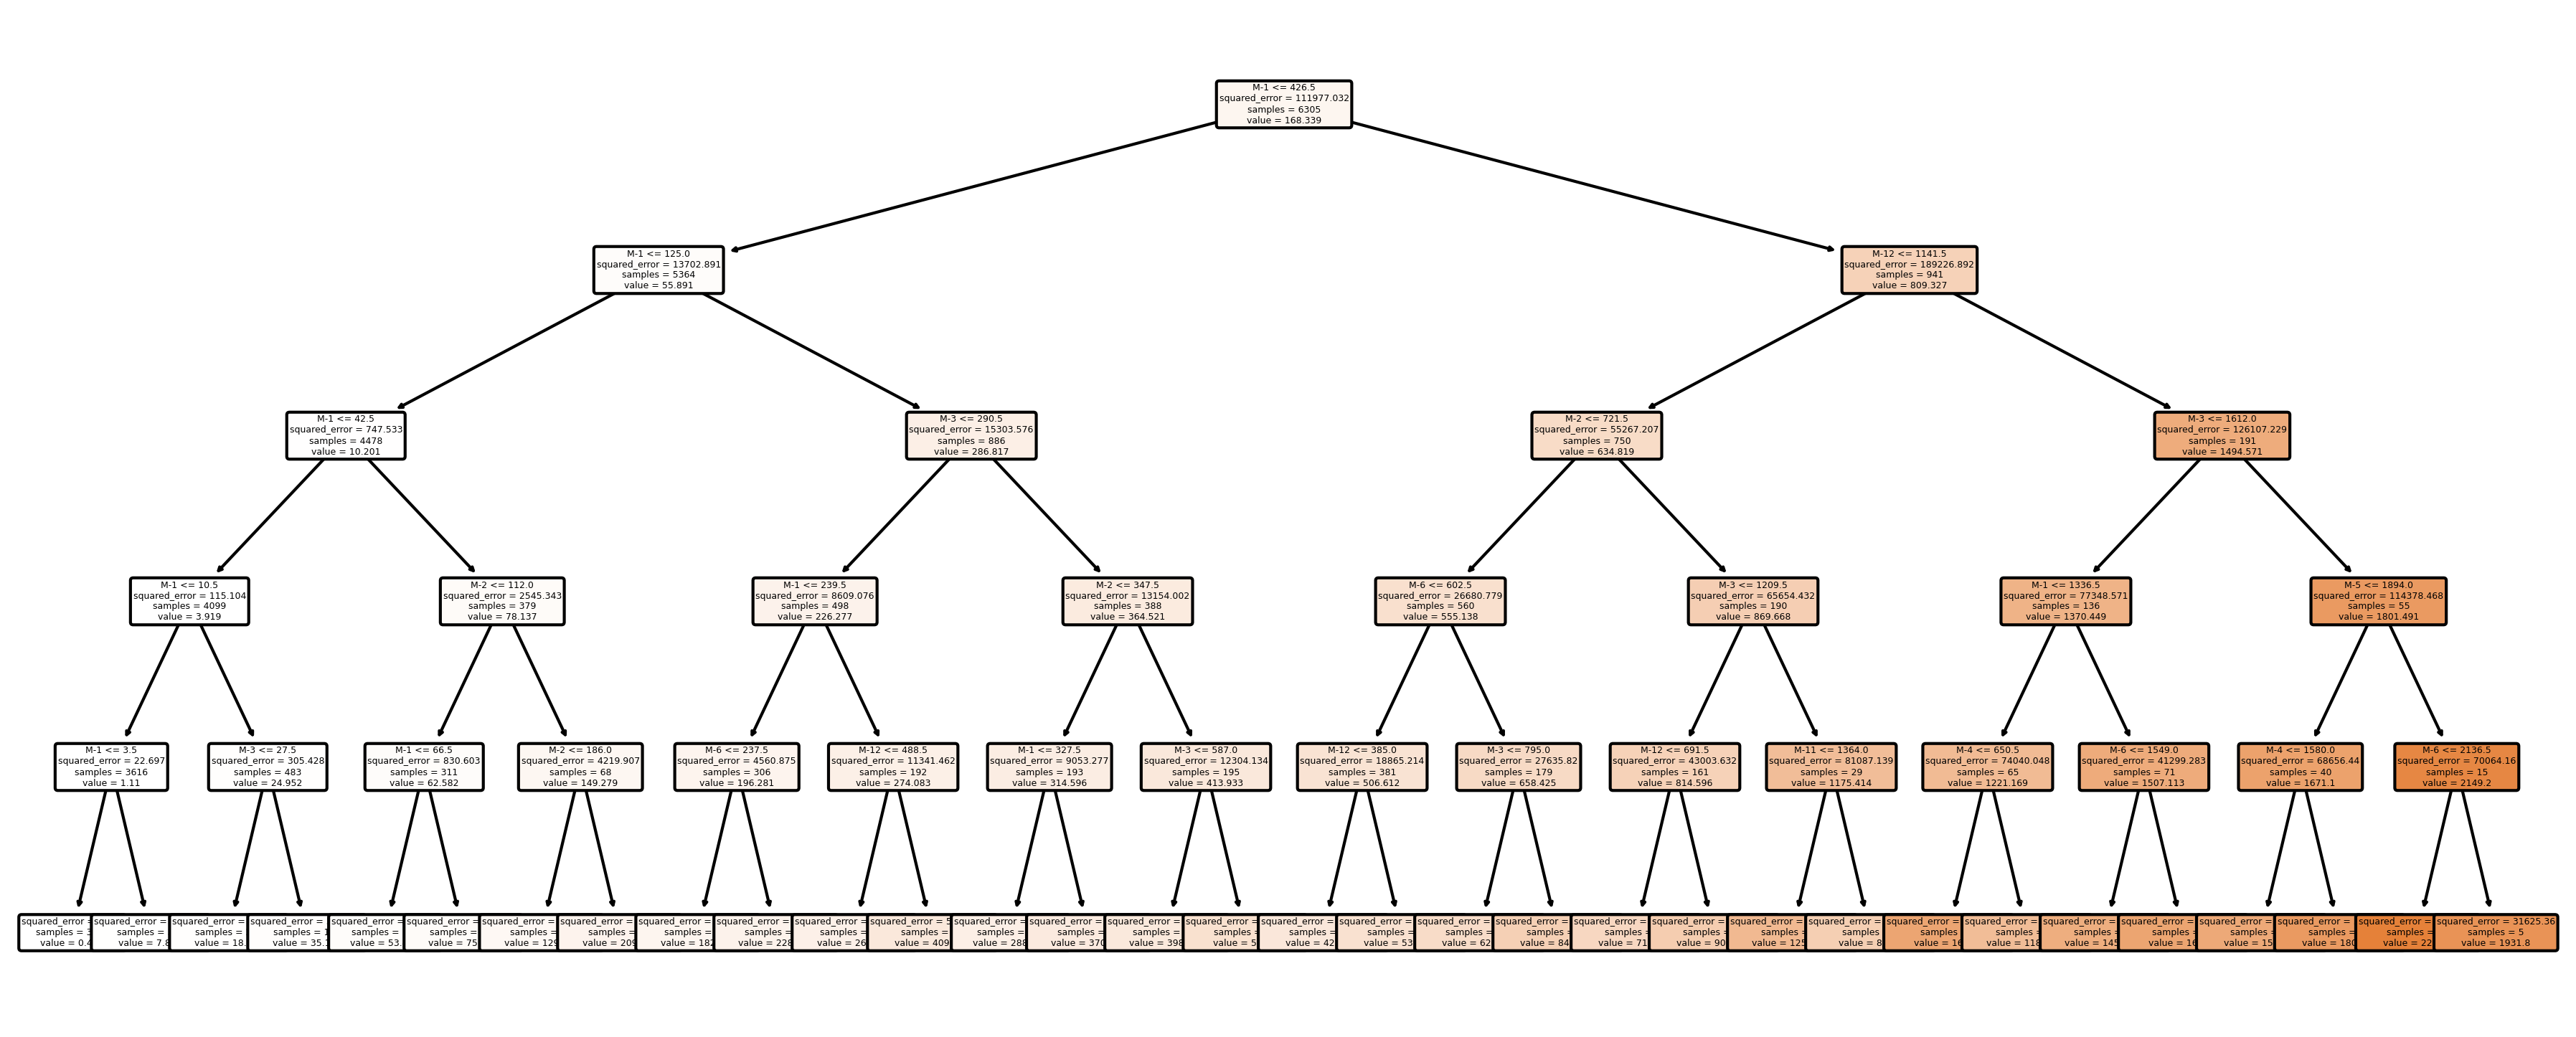

In [69]:
from sklearn.tree import plot_tree
fig = plt.figure(figsize=(15,6), dpi=300)
ax = fig.gca()
plot_tree(tree_r, fontsize=3, feature_names=[f'M{x-12}' for x in range(12)], rounded=True, filled=True, ax=ax)
fig.savefig('Regression Tree.PNG')

In [70]:
y = np.array([8,12,25,40,50,65,36,61,88,63])
month_train = np.arange(1,11,1,dtype=int)
month_test = np.arange(11,13,1,dtype=int)

data_horizon = {
    "Month":month_train,
    "Value":y
}
data = pd.DataFrame(data_horizon)
data

,Month,Value
0,1,8
1,2,12
2,3,25
3,4,40
4,5,50
5,6,65
6,7,36
7,8,61
8,9,88
9,10,63


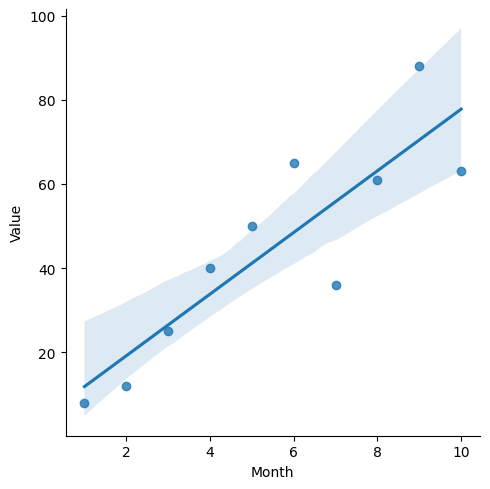

In [71]:
import seaborn as sns
import matplotlib as plt
from sklearn.linear_model import LinearRegression

sns.lmplot(x="Month", y="Value", data=data)

In [72]:

X_train = np.array(data['Month']).reshape(-1, 1)
y = np.array(data['Value']).reshape(-1, 1)

In [73]:
regr = LinearRegression()
regr.fit(X_train,y)
regr.intercept_

array([4.46666667])